In [1]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten,BatchNormalization ,Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

In [3]:
tf.random.set_seed(42)

img_shape = (28, 28, 1)
z_dim = 100

출력층에서 tanh 활성화 함수를 사용하여 출력 값을 [-1, 1] 범위로 조정하는 이유는 시그모이드 함수보다 조금 더 또렷하게 만들어주기 때문이다.

In [4]:
def build_generator(img_shape, z_dim):
    return Sequential([
        Dense(128, input_dim=z_dim),
        # BatchNormalization(),
        LeakyReLU(alpha=0.02),
        Dense(28*28*1, activation='tanh'),
        Reshape(img_shape)
    ])

In [5]:
def build_discriminator(img_shape):
    return Sequential([
        Flatten(input_shape = img_shape),
        Dense(128),
        LeakyReLU(alpha=0.02),
        Dense(1, activation='sigmoid')
    ])

In [6]:
def build_gan(generator, discriminator):
    model = Sequential([
        generator,
        discriminator,
    ])
    return model

In [7]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
generator = build_generator(img_shape, z_dim)
discriminator.trainable = False # 생성자 훈련할 때 판별자 파라미터 동결하기
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


In [8]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (X_train, _), (_, _) = mnist.load_data()

    X_train = X_train / 127.5 - 1.0 # [-1,1]사이로 스케일 조정
    X_train = X_train[...,np.newaxis]
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        idx = np.random.randint(0, X_train.shape[0], batch_size) #batch 랜덤 인덱스
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        """
        -------------------------
                generator
        -------------------------
        """

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            # 생성된 이미지 샘플 출력
            sample_images(generator)

1000 [D loss: 0.019338, acc: 100.00%] [G loss: 5.216468]
2000 [D loss: 0.140622, acc: 98.44%] [G loss: 2.836480]
3000 [D loss: 0.299888, acc: 89.06%] [G loss: 3.973175]
4000 [D loss: 0.057645, acc: 98.44%] [G loss: 6.520981]
5000 [D loss: 0.220156, acc: 92.19%] [G loss: 4.389954]
6000 [D loss: 0.349745, acc: 87.50%] [G loss: 4.574872]
7000 [D loss: 0.296487, acc: 90.62%] [G loss: 3.783598]
8000 [D loss: 0.210833, acc: 89.06%] [G loss: 4.903217]
9000 [D loss: 0.360978, acc: 87.50%] [G loss: 4.241798]
10000 [D loss: 0.278369, acc: 85.94%] [G loss: 2.868929]
11000 [D loss: 0.403528, acc: 87.50%] [G loss: 3.317328]
12000 [D loss: 0.438701, acc: 81.25%] [G loss: 1.807141]
13000 [D loss: 0.654418, acc: 73.44%] [G loss: 2.280880]
14000 [D loss: 0.398737, acc: 79.69%] [G loss: 1.573083]
15000 [D loss: 0.534473, acc: 68.75%] [G loss: 1.626523]
16000 [D loss: 0.508463, acc: 76.56%] [G loss: 2.671928]
17000 [D loss: 0.361906, acc: 81.25%] [G loss: 2.909270]
18000 [D loss: 0.350065, acc: 84.38%] [

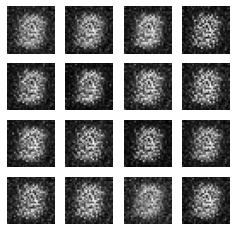

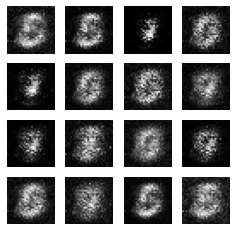

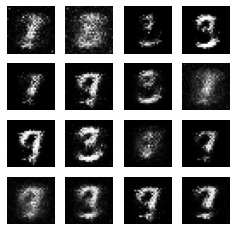

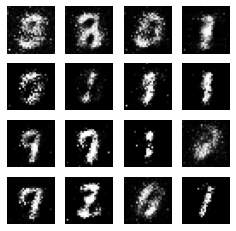

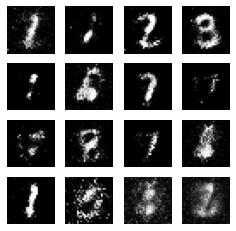

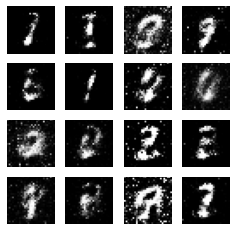

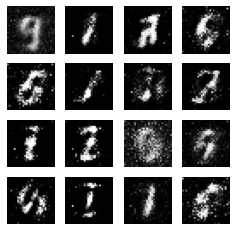

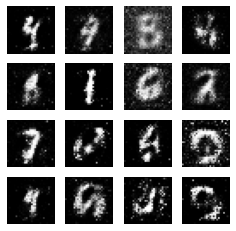

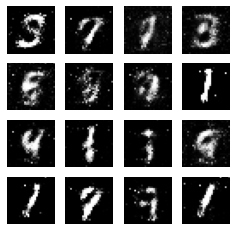

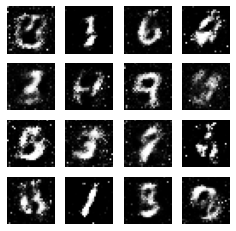

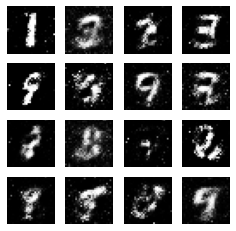

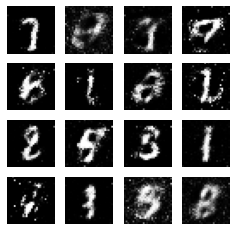

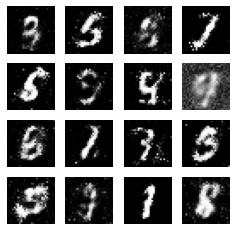

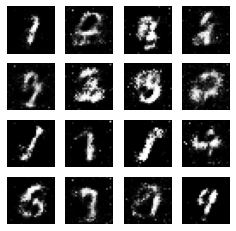

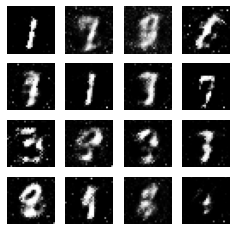

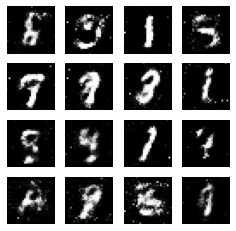

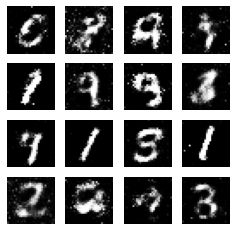

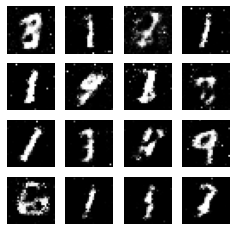

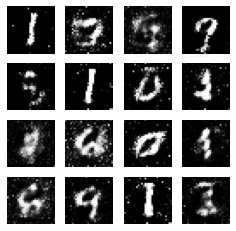

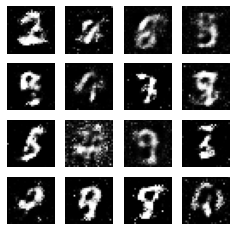

In [9]:
iterations = 20000
batch_size = 32
sample_interval = 1000

train(iterations, batch_size, sample_interval)